# Merge Table

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

For each orderid in the test set, you should predict a space-delimited list of productids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

In [3]:
from sklearn.utils import shuffle
prior = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/order_products__prior.csv')
prior = prior[0:10000000].reset_index()
prior.head()

,index,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0


In [4]:
prior.shape

(10000000, 5)

In [5]:
train = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
train.shape

(1384617, 4)

In [7]:
order_products_all = pd.concat([prior, train], axis=0)
order_products_all.shape

(11384617, 5)

Firstly, let’s explore the data for Instacart products. There are 2 CSV files, namely order_products_train and order_products_prior, that specify which products were purchased in each order. More specifically, order_products_prior contains previous order products for all customers and order_products_train contains the latest order products for some customers only.

* The ID of the order (order_id)
* The ID of the product (product_id)
* The ordering of that product in the order (add_to_cart_order)
* Whether that product was reordered (reordered).

In [8]:
orders = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

* The ID of the order (order_id)
* The ID of the customer (user_id)
* Which evaluation datasets that the order is in — prior, train, or test (eval_set)
* The number of the order (order_number)
* The day of the week when that order occurred (order_dow)
* The hour of the day when that order occurred (order_hour_of_day)
* The number of days since the previous order (days_since_prior_order)

This is my undrstanding of the dataset structur:

users are identified by user_id in the orders csv file. Each row of the orders csv fil represents an order made by a user. Order are identified by order_id;

Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user;

each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order;

for each user we may have n-1 prior orders and 1 train order OR n-1 prior orders and 1 test order in which we have to state what products have been reordered.

In [10]:
print(orders.shape)
print(prior.shape)
print(train.shape)

(3421083, 7)
(10000000, 5)
(1384617, 4)


In [11]:
products = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
aisles = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
departments = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [14]:
print(orders.shape)
print(prior.shape)
print(train.shape)
print(products.shape)
print(aisles.shape)
print(departments.shape)

(3421083, 7)
(10000000, 5)
(1384617, 4)
(49688, 4)
(134, 2)
(21, 2)


In [0]:
a = pd.merge(order_products_all,products, on = ['product_id','product_id'])
a = pd.merge(a,orders,on=['order_id','order_id'])

In [16]:
a = pd.merge(a,departments,on=['department_id','department_id'])
df_all = pd.merge(a,aisles,on=['aisle_id','aisle_id'])
df_all.head(5)

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,0.0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs,eggs
1,237.0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,dairy eggs,eggs
2,1084.0,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,dairy eggs,eggs
3,3039.0,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,dairy eggs,eggs
4,3709.0,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,dairy eggs,eggs


In [17]:
df_all.shape

(11384617, 16)

In [18]:
df_all['eval_set'].value_counts()

prior    10000000
train     1384617
Name: eval_set, dtype: int64

In [19]:
df_all.isnull().sum()

index                     1384617
order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order     643267
department                      0
aisle                           0
dtype: int64

In [20]:
df_all.columns

Index(['index', 'order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'user_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'department', 'aisle'],
      dtype='object')

# EDA

### Number of order per product add to cart

In [0]:
#order_id: id 1 dơn hàng (có thể bao gồm nhiều sản phẩm xếp theo thứ tự trong đó - add to cart order)
grouped = df_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped
#Ý nghĩa: group tất cả đơn hàng lại, hiển thị xem tối đa bao nhiêu sản phẩm trong từng đơn hàng
#Bắt buộc phải là max vì khi group lại 1 đơn hàng sẽ có các sản phẩm theo số thứ tự: 1,2,3,4...
# Cần phải xác định xem nên lấy trung bình hay là lấy max. Phải lấy max mới đúng ý nghĩa

,order_id,add_to_cart_order
0,1,8
1,2,9
2,3,8
3,4,13
4,5,26
...,...,...
1122918,3421049,6
1122919,3421056,5
1122920,3421058,8
1122921,3421063,4


In [0]:
grouped = grouped.add_to_cart_order.value_counts()
grouped
# Đếm ố lượng sản phẩm tối đa thường được order trong 1 đơn hàng

5      79458
6      78909
4      76779
7      76611
3      71864
       ...  
89         1
87         1
86         1
83         1
137        1
Name: add_to_cart_order, Length: 100, dtype: int64

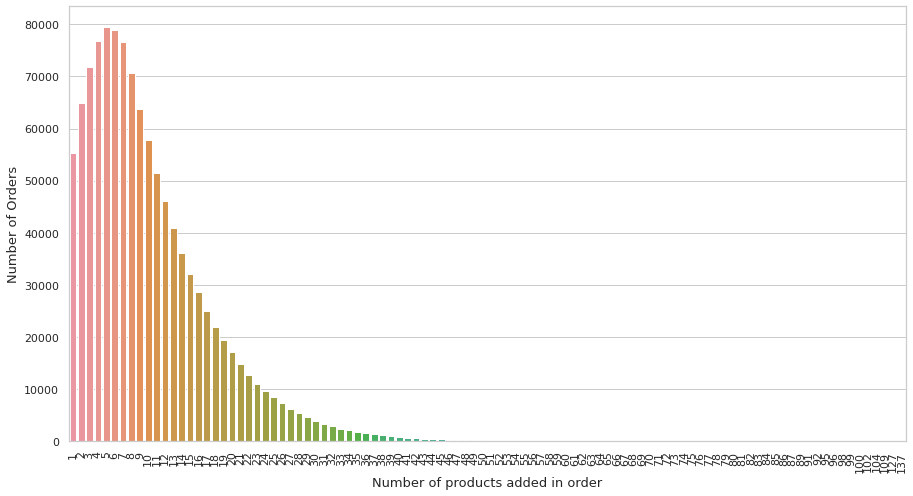

In [0]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

### Most buy product

In [0]:
a=df_all['product_name'].value_counts()[:10]
a

Banana                    164831
Bag of Organic Bananas    132684
Organic Strawberries       92890
Organic Baby Spinach       84068
Organic Hass Avocado       73172
Organic Avocado            61678
Large Lemon                55209
Strawberries               50440
Limes                      49321
Organic Whole Milk         47512
Name: product_name, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

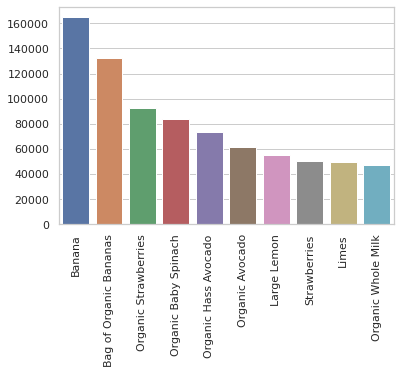

In [0]:
f, ax = plt.subplots()
sns.barplot(a.index, a.values)
plt.xticks(rotation='vertical')

### Which reordered product

In [0]:
reordered_products=df_all.groupby(['product_id','product_name']).agg({'reordered':'sum'}).\
sort_values(by='reordered',ascending=False)[:10].reset_index()

reordered_products

,product_id,product_name,reordered
0,24852,Banana,139682
1,13176,Bag of Organic Bananas,110876
2,21137,Organic Strawberries,72324
3,21903,Organic Baby Spinach,65496
4,47209,Organic Hass Avocado,58321
5,47766,Organic Avocado,47187
6,27845,Organic Whole Milk,39521
7,47626,Large Lemon,38618
8,27966,Organic Raspberries,36349
9,16797,Strawberries,35458


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

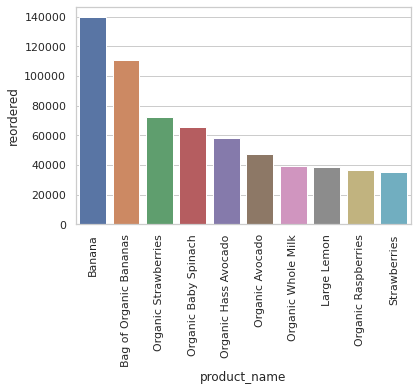

In [0]:
f, ax = plt.subplots()
sns.barplot(reordered_products.product_name, reordered_products.reordered)
plt.xticks(rotation='vertical')

### Who is the most buyer 

In [0]:
top_user=df_all['user_id'].value_counts()[:10]
top_user

176478    1221
52008     1179
160106    1166
137629    1090
74315     1084
201268    1045
182401    1031
57546      948
17738      928
142131     921
Name: user_id, dtype: int64

In [0]:
grouped  = df_all.groupby(['user_id']).count()['product_id'].\
sort_values(ascending=False)[:10].reset_index()
grouped

,user_id,product_id
0,176478,1221
1,52008,1179
2,160106,1166
3,137629,1090
4,74315,1084
5,201268,1045
6,182401,1031
7,57546,948
8,17738,928
9,142131,921


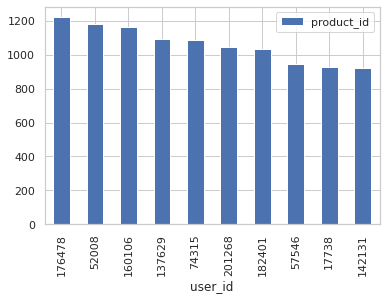

In [0]:
grouped.plot.bar(x='user_id',y='product_id')
plt.show()

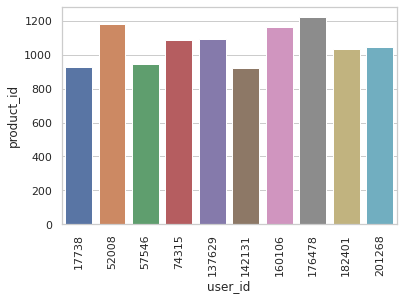

In [0]:
f, ax = plt.subplots()
sns.barplot('user_id','product_id',data=grouped)
plt.xticks(rotation='vertical')
plt.show()

### Check one user, id=6710

In [0]:
user_a=df_all[df_all['user_id']==6710].sort_values(by=['order_id','add_to_cart_order'])
user_a[:5]

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
6124502,206939.0,21820,24778,1,0,Wild Sea Sardines In Olive Oil,15,12,6710,prior,48,5,11,2.0,meat seafood,packaged seafood
8510180,206940.0,21820,19054,2,1,Gluten Free Honey Mustard Pretzels,107,19,6710,prior,48,5,11,2.0,snacks,chips pretzels
8510177,206941.0,21820,45447,3,1,Gluten Free Covered Pretzels Yogurt,107,19,6710,prior,48,5,11,2.0,snacks,chips pretzels
8510181,206942.0,21820,42478,4,0,Gluten Free Buffalo Style Pretzels,107,19,6710,prior,48,5,11,2.0,snacks,chips pretzels
8794492,206943.0,21820,4265,5,0,Chocolate Covered Gluten Free Wafer Bites,61,19,6710,prior,48,5,11,2.0,snacks,cookies cakes


In [0]:
user_a['product_name'].value_counts()[:10]

Tortilla Chips, Clasico, Jalapeno Lime    25
Organic Reduced Fat 2% Milk               21
Organic Unsweetened Almond Milk           21
Organic Good Seed Bread                   19
Baby Spinach                              18
Peach Pear Flavored Sparkling Water       17
Uncured Black Forest Ham                  16
Organic Baby Spinach                      14
Sparkling Water Grapefruit                14
Lime Sparkling Water                      13
Name: product_name, dtype: int64

### Reorder Frequency:

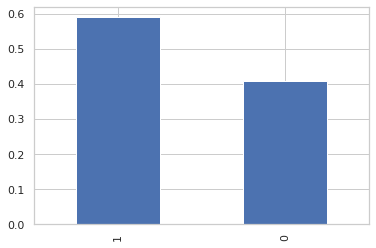

In [0]:
df_all['reordered'].value_counts(normalize=True).plot.bar()

### Which day most buy

In [0]:
day_buy=df_all['order_dow'].value_counts()
day_buy

0    2238540
1    1954371
6    1592938
5    1471290
2    1467275
3    1339320
4    1320883
Name: order_dow, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

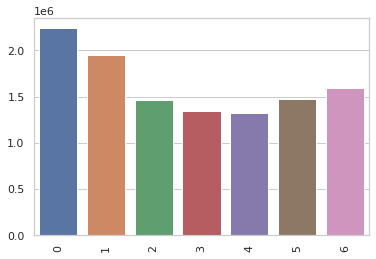

In [0]:
f, ax = plt.subplots()
sns.barplot(day_buy.index, day_buy.values)
plt.xticks(rotation='vertical')

### Which time most buy

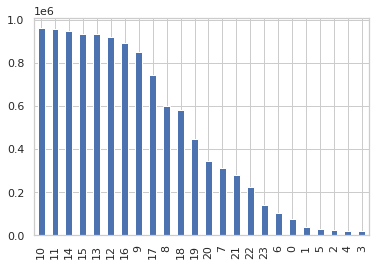

In [0]:
time_buy=df_all['order_hour_of_day'].value_counts()
time_buy.plot.bar()

In [0]:
grouped  = df_all.groupby(['order_hour_of_day']).count()['product_id'].\
sort_values(ascending=False).reset_index().rename(columns={'product_id':'Total'})
grouped[:10]

,order_hour_of_day,Total
0,10,961497
1,11,958193
2,14,949519
3,15,934418
4,13,932867
5,12,920146
6,16,891436
7,9,852229
8,17,742903
9,8,598220


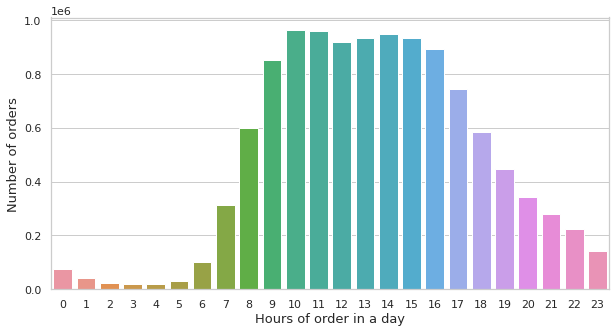

In [0]:
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(grouped.order_hour_of_day, grouped.Total)
#plt.xticks(rotation='vertical')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

### Period of Reorders:

In [0]:
filter_=df_all['order_id']==1000
df_all[filter_]

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
339209,9715.0,1000,35951,3,0,Organic Unsweetened Almond Milk,91,16,49841,prior,7,1,17,5.0,dairy eggs,soy lactosefree
3632905,9718.0,1000,26800,6,1,Organic Baby Kale Mix,123,4,49841,prior,7,1,17,5.0,produce,packaged vegetables fruits
4871132,9713.0,1000,20073,1,1,Jazz Apple,24,4,49841,prior,7,1,17,5.0,produce,fresh fruits
5463367,9716.0,1000,3025,4,1,Cacao Sweet Raw Chocolate Nibs,17,13,49841,prior,7,1,17,5.0,pantry,baking ingredients
7578777,9719.0,1000,8981,7,1,No. 01 Organic Vegan Cold Pressed Juice Kale S...,31,7,49841,prior,7,1,17,5.0,beverages,refrigerated
8378513,9717.0,1000,35734,5,1,Whole Chia Seeds,117,19,49841,prior,7,1,17,5.0,snacks,nuts seeds dried fruit
8378514,9714.0,1000,34590,2,1,Pitted Dates,117,19,49841,prior,7,1,17,5.0,snacks,nuts seeds dried fruit


In [0]:
reorders_day = df_all.groupby("days_since_prior_order")["order_id"].count().reset_index()
#reorders_day

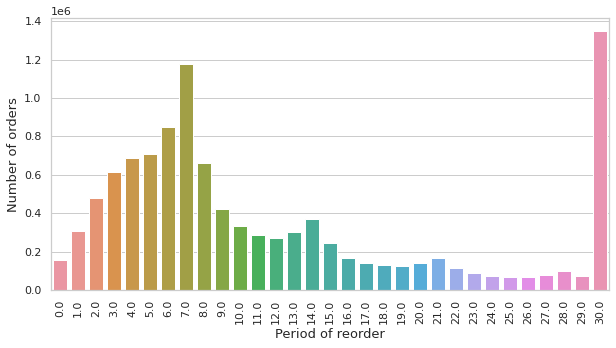

In [0]:
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(reorders_day.days_since_prior_order, reorders_day.order_id)
plt.xticks(rotation='vertical')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

### Total order

In [0]:
grouped = df_all["order_id"].nunique()
grouped

1122923

### Total user

In [0]:
grouped = df_all["user_id"].nunique()
grouped

199381

### Order made by each customer

In [0]:
cust_order = df_all.groupby('user_id').agg({'order_id':'count'})\
.rename(columns={'order_id':'Total'}).reset_index()\
.sort_values(by='Total',ascending=False)[:10]

cust_order

,user_id,Total
170636,176478,1221
50308,52008,1179
154822,160106,1166
133031,137629,1090
71849,74315,1084
194602,201268,1045
176386,182401,1031
55654,57546,948
17153,17738,928
137389,142131,921


In [0]:
grouped  = df_all.groupby(['user_id'])['order_id'].count().\
reset_index().rename(columns={'order_id':'Total'}).\
sort_values(by='Total',ascending=False)[:10]

grouped

,user_id,Total
170636,176478,1221
50308,52008,1179
154822,160106,1166
133031,137629,1090
71849,74315,1084
194602,201268,1045
176386,182401,1031
55654,57546,948
17153,17738,928
137389,142131,921


In [0]:
grouped=df_all['user_id'].value_counts()
grouped

176478    1221
52008     1179
160106    1166
137629    1090
74315     1084
          ... 
141729       1
173780       1
3716         1
18923        1
16199        1
Name: user_id, Length: 199381, dtype: int64

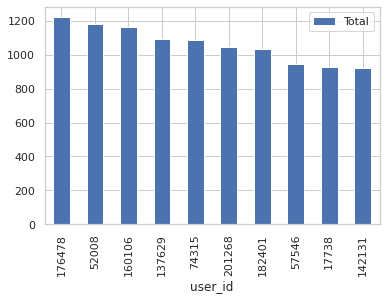

In [0]:
cust_order.plot.bar('user_id','Total')

### Best Selling Departments (number of Orders)

In [0]:
grouped  = df_all.groupby(['department'])['product_id'].count().\
reset_index().rename(columns={'product_id':'Total'}).\
sort_values(by='Total',ascending=False)[:10]

grouped

,department,Total
19,produce,3334276
7,dairy eggs,1887208
20,snacks,1010063
3,beverages,942338
10,frozen,789148
16,pantry,658538
2,bakery,410866
6,canned goods,375359
8,deli,368533
9,dry goods pasta,305859


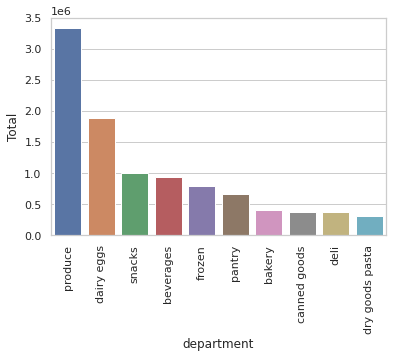

In [0]:
f, ax = plt.subplots()
sns.barplot(grouped.department, grouped.Total)
plt.xticks(rotation='vertical')
plt.show()

### Most important Aisles over all Departments (by number of Products)

In [0]:
grouped = df_all.groupby("aisle").aggregate({'product_id': 'count'})\
.reset_index().rename(columns={'product_id':'Total'})\
.sort_values(by='Total',ascending=False)[:10]

grouped

,aisle,Total
50,fresh fruits,1275046
53,fresh vegetables,1204449
98,packaged vegetables fruits,623330
133,yogurt,503358
93,packaged cheese,343610
83,milk,307655
131,water seltzer sparkling water,295228
25,chips pretzels,255131
119,soy lactosefree,223117
11,bread,203833


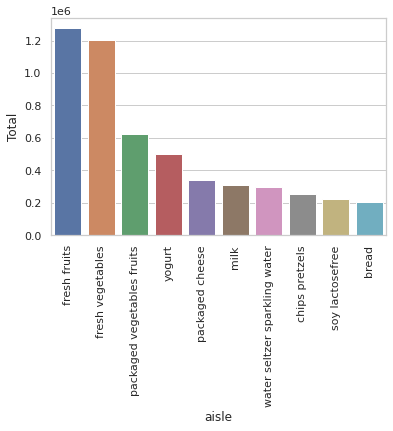

In [0]:
f, ax = plt.subplots()
sns.barplot(grouped.aisle, grouped.Total)
plt.xticks(rotation='vertical')
plt.show()

### Most important Aisles in each Department (by number of Products)

In [0]:
grouped = df_all.groupby(["department", "aisle"]).aggregate({'product_id': 'count'})\
.reset_index().rename(columns={'product_id':'Total'}).sort_values(by='Total',ascending=False)

grouped

,department,aisle,Total
118,produce,fresh fruits,1275046
120,produce,fresh vegetables,1204449
122,produce,packaged vegetables fruits,623330
42,dairy eggs,yogurt,503358
38,dairy eggs,packaged cheese,343610
...,...,...,...
68,household,kitchen supplies,3302
6,babies,baby bath body care,2921
5,babies,baby accessories,2799
99,personal care,beauty,2148


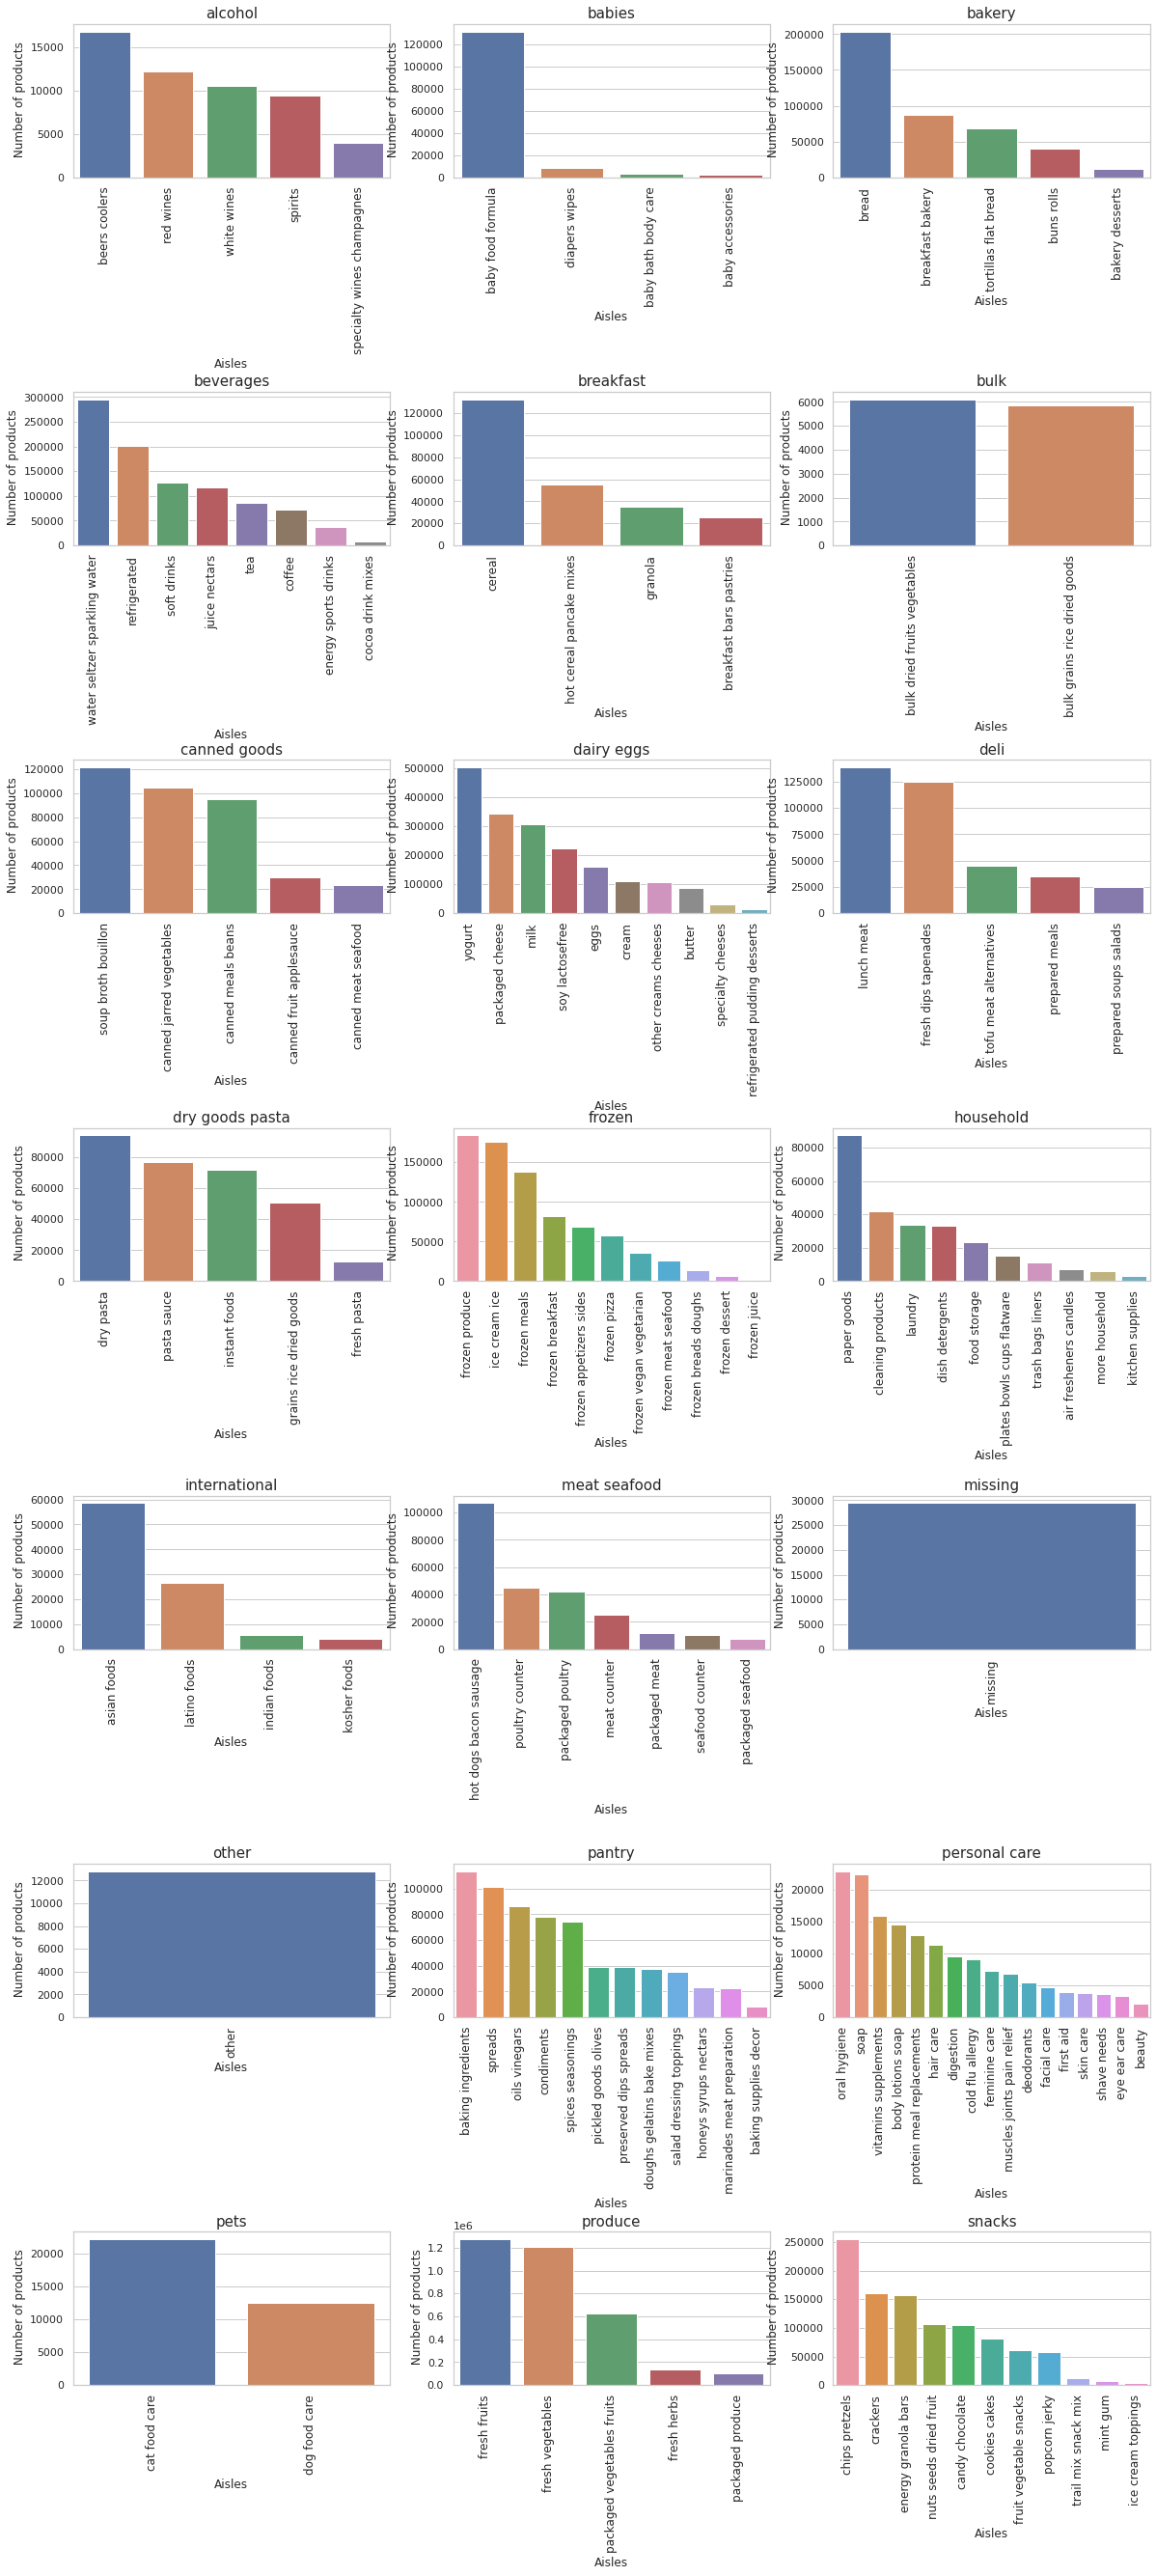

In [0]:
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

# Customer Segments

## PCA

In [21]:
len(df_all['aisle'].unique())

134

In [22]:
df_all.head()

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,0.0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs,eggs
1,237.0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,dairy eggs,eggs
2,1084.0,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,dairy eggs,eggs
3,3039.0,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,dairy eggs,eggs
4,3709.0,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,dairy eggs,eggs


In [23]:
df_all.shape

(11384617, 16)

In [24]:
cust_prod = pd.crosstab(df_all['user_id'], df_all['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,3,0,0,1,0,0,0,4,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,9,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,2
8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,1,1,0,0,0,0,0,0
9,0,0,0,0,5,0,2,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,14


In [25]:
cust_prod.shape

(199381, 134)

In [0]:
df_all['user_id'].nunique()

199381

In [0]:
cust_prod.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            206200, 206201, 206202, 206203, 206204, 206205, 206206, 206207,
            206208, 206209],
           dtype='int64', name='user_id', length=199381)

In [0]:
cust_prod.tail(5)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
206205,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
206206,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,6,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
206207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4
206208,0,1,0,0,1,0,1,0,0,0,0,12,0,0,0,0,0,4,1,0,1,1,0,0,2,3,0,0,1,0,1,0,0,6,0,0,0,0,0,3,...,0,1,2,0,10,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,8,0,0,3,0,1,0,0,1,0,0,0,0,0,5
206209,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,1,0,3,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,4,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
cust_prod.shape

(199381, 134)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [0]:
ps = pd.DataFrame(pca_samples)
print(ps.shape)
ps.head()

(199381, 6)


,0,1,2,3,4,5
0,-6.994063,2.209998,-1.554882,0.310592,0.107417,-0.409192
1,3.052201,10.384335,-4.092032,2.154508,-1.767690,-0.501686
2,-7.250897,0.879384,-2.092729,-0.227920,-0.079459,-0.567953
3,-9.353014,0.009721,-1.468608,1.151013,-0.077415,0.232588
4,-5.816852,-1.356431,0.052719,1.029261,0.623076,-1.703727


Text(0.5, 0, 'z')

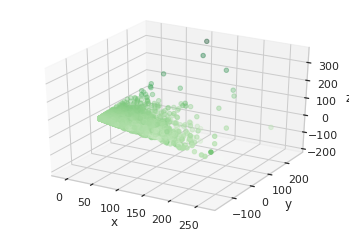

In [0]:
from mpl_toolkits import mplot3d
# Data for three-dimensional scattered points
ax = plt.axes(projection='3d')

xdata = ps[0]
ydata = ps[1]
zdata = ps[2]

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


In [0]:
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
tocluster

(199381, 2)


,4,1
0,0.107417,2.209998
1,-1.767690,10.384335
2,-0.079459,0.879384
3,-0.077415,0.009721
4,0.623076,-1.356431
...,...,...
199376,-0.078329,5.794993
199377,0.250167,-2.203851
199378,0.322204,0.976958
199379,1.187408,5.017585


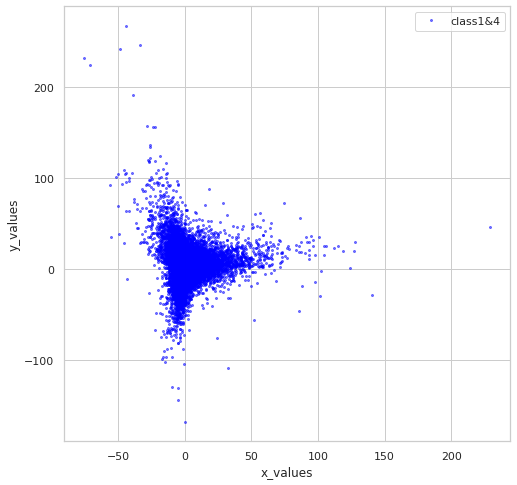

In [0]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1&4')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -3.30140279  19.97789467]
 [ -0.03478165   0.12210958]
 [ -1.21019634 -12.53375171]
 [ 28.1792023    9.31192833]]


In [0]:
print(c_preds.shape)
print (c_preds[0:100])

(199381,)
[1 0 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1]


Counter({1: 174685, 2: 15256, 0: 7670, 3: 1770})


<BarContainer object of 4 artists>

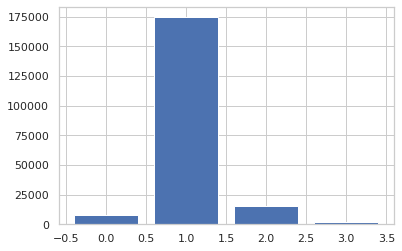

In [0]:
import collections, numpy
w=collections.Counter(c_preds)
print(w)
plt.bar(w.keys(), w.values())

['blue', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'purple', 'blue', 'purple']


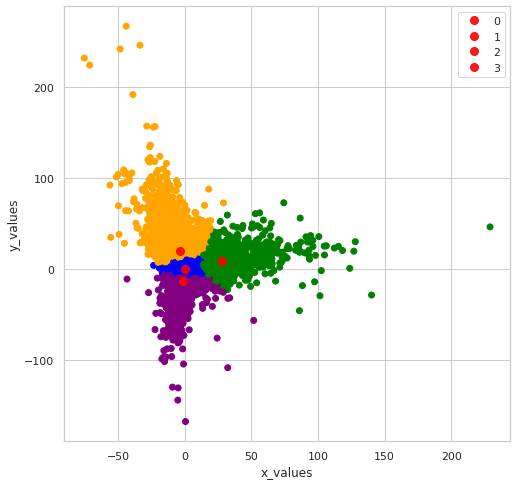

In [0]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [0]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,3,0,0,1,0,0,0,4,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,9,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,1,1,0,0,0,0,0,0,2
9,0,0,0,0,5,0,2,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,14,1


In [0]:
clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,3,0,0,1,0,0,0,4,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7
27,0,0,0,0,0,0,0,0,0,0,0,4,2,4,0,0,0,0,0,0,0,0,0,0,0,7,1,0,4,0,0,0,0,3,0,0,0,1,0,0,...,0,0,1,0,9,1,0,0,0,6,0,0,0,0,0,0,43,0,0,0,0,0,2,6,0,10,0,0,0,0,2,1,0,0,0,0,0,33,0,66
90,0,1,0,0,0,0,0,0,0,0,1,0,0,6,0,0,0,0,47,0,0,0,0,0,31,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,2,0,0,0,0,0,0,29,0,9
152,0,0,0,0,8,0,0,0,0,0,0,2,0,0,0,0,0,4,0,5,1,2,0,0,2,0,0,0,0,0,2,0,5,0,0,0,0,3,0,0,...,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,2,17,0,0,0,0,3,0,3,0,0,0,1,2,0,26
209,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206051,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,12,1,0,0,0,0,4,26,0,0,0,0,0,6,5,0,0,0,0,0,0,0,...,0,0,0,0,6,1,0,0,1,4,0,0,0,9,0,0,0,0,0,0,0,0,0,3,0,10,0,0,2,0,1,7,0,0,0,1,0,1,0,1
206062,0,0,0,0,0,0,2,0,0,0,0,4,13,2,0,0,0,2,4,0,0,0,0,0,0,5,0,0,1,0,2,3,4,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,2,0,0,0,0,3,2,0,0,0,0,0,0,0,5
206124,2,0,0,0,0,0,0,0,0,0,1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,18,0,0,0,0,0,0,...,0,0,0,0,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,2,15,0,0,0,1,0,0,0,14


In [0]:
len(clust_prod.drop('cluster',axis=1).columns)

134

(199381, 135)


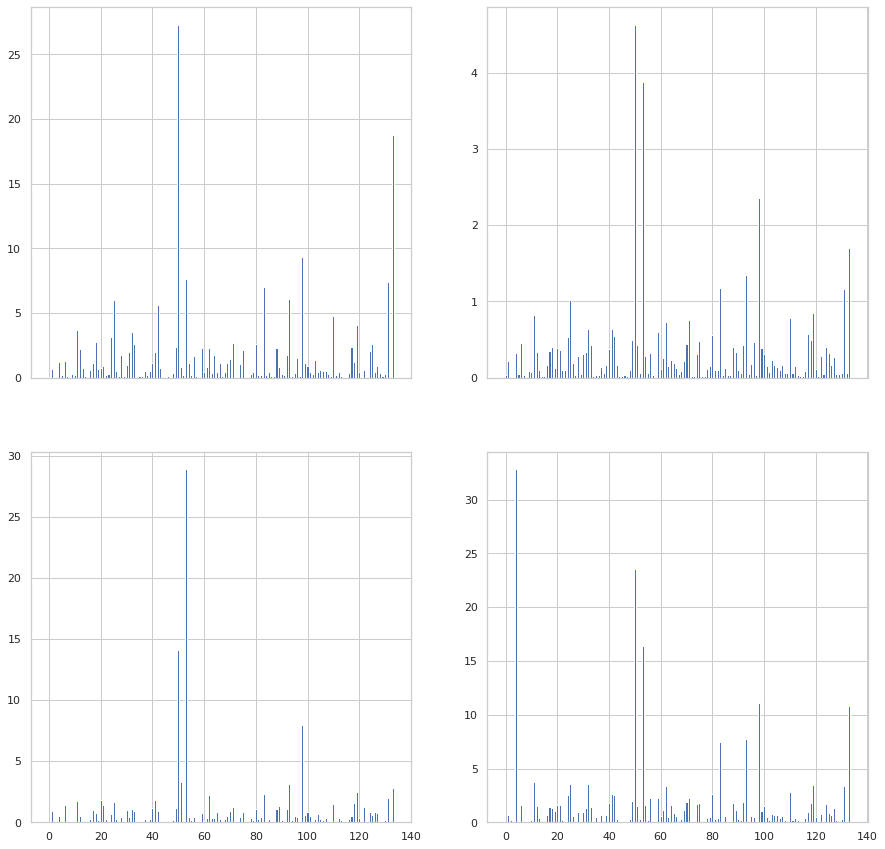

In [0]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()
# Biểu thị số sản phẩm được mua nhiều trong từng tệp khách hàng

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [0]:
c0

aisle
air fresheners candles            0.078879
asian foods                       0.662581
baby accessories                  0.041330
baby bath body care               0.041851
baby food formula                 1.207432
                                   ...    
trash bags liners                 0.152934
vitamins supplements              0.273272
water seltzer sparkling water     7.411604
white wines                       0.078879
yogurt                           18.751760
Length: 134, dtype: float64

In [0]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     27.308735
yogurt                           18.751760
packaged vegetables fruits        9.341199
fresh vegetables                  7.614081
water seltzer sparkling water     7.411604
milk                              7.013168
packaged cheese                   6.078748
chips pretzels                    6.010430
energy granola bars               5.638462
refrigerated                      4.784615
dtype: float64

In [0]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     4.632819
fresh vegetables                 3.872319
packaged vegetables fruits       2.350534
yogurt                           1.706363
packaged cheese                  1.348278
milk                             1.175012
water seltzer sparkling water    1.160323
chips pretzels                   1.016813
soy lactosefree                  0.845241
bread                            0.814706
dtype: float64

In [0]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 28.876311
fresh fruits                     14.063516
packaged vegetables fruits        7.964670
fresh herbs                       3.288739
packaged cheese                   3.126573
yogurt                            2.772614
soy lactosefree                   2.493904
milk                              2.325249
frozen produce                    2.238332
water seltzer sparkling water     1.948545
dtype: float64

In [0]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula             32.813559
fresh fruits                  23.588136
fresh vegetables              16.427119
packaged vegetables fruits    11.057062
yogurt                        10.823164
packaged cheese                7.775706
milk                           7.419774
bread                          3.742373
crackers                       3.577966
chips pretzels                 3.532203
dtype: float64

A first analysis of the clusters confirm the initial hypothesis that:

fresh fruits

fresh vegetables

packaged vegetables fruits

yogurt

packaged cheese

milk

water seltzer sparkling water

chips pretzels

are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [0]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,27.308735,7.614081,9.341199,18.751760,6.078748,7.013168,7.411604,6.010430
1,4.632819,3.872319,2.350534,1.706363,1.348278,1.175012,1.160323,1.016813
2,14.063516,28.876311,7.964670,2.772614,3.126573,2.325249,1.948545,1.648991
3,23.588136,16.427119,11.057062,10.823164,7.775706,7.419774,3.368927,3.532203


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters.

It seems people of cluster 1 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [0]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,30.502422,8.504528,10.433629,20.944731,6.789643,7.833340,8.278372,6.713335
1,26.837535,22.432020,13.616447,9.884818,7.810464,6.806748,6.721654,5.890314
2,22.420385,46.035289,12.697462,4.420166,4.984456,3.706966,3.106416,2.628859
3,28.083758,19.557935,13.164409,12.885932,9.257665,8.833896,4.011005,4.205400


In [0]:
c0.sort_values(ascending=False)[10:15]

aisle
soy lactosefree    4.070274
bread              3.714211
crackers           3.487614
cereal             3.099218
candy chocolate    2.712777
dtype: float64

In [0]:
c1.sort_values(ascending=False)[10:15]

aisle
refrigerated      0.778155
ice cream ice     0.757821
frozen produce    0.722712
eggs              0.641709
crackers          0.638721
dtype: float64

In [0]:
c2.sort_values(ascending=False)[10:15]

aisle
canned jarred vegetables    1.823479
eggs                        1.806961
bread                       1.730729
chips pretzels              1.648991
soup broth bouillon         1.543524
dtype: float64

In [0]:
c3.sort_values(ascending=False)[10:15]

aisle
soy lactosefree                  3.502825
water seltzer sparkling water    3.368927
frozen produce                   3.353107
refrigerated                     2.774576
eggs                             2.625989
dtype: float64